# Look into the sea level budget data from Frederikse et al. 2020

In [2]:
import importlib
import sys
sys.path.append('../code')

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

import SeaLevelContrib as slc

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [3]:
importlib.reload(slc)

<module 'SeaLevelContrib' from '/Users/dewilebars/Projects/SLBudget/notebooks/../code/SeaLevelContrib.py'>

In [4]:
def rotate_longitude(ds):
    '''Rotate the longitude of an xarray dataset from [0,360] to [-180,180]'''
    
    if 'lon' in ds.dims:
        lon = 'lon'
    elif 'longitude' in ds.dims:
        lon = 'longitude'
    else:
        print('Longitude not found in dimensions')
        
    ds[lon] = np.where(ds[lon]>180, ds[lon]-360, ds[lon])
    ds = ds.reindex({ lon : np.sort(ds[lon])})
    
    return ds

In [5]:
data_dir = '../data/Frederikse2020/'

## Terrestrial water storage

In [6]:
tws_ds = xr.open_dataset(f'{data_dir}tws.nc')
tws_ds = rotate_longitude(tws_ds)

In [7]:
tws_ds

<xarray.Dataset>
Dimensions:        (lon: 720, lat: 360, time: 119)
Coordinates:
  * lon            (lon) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * lat            (lat) float32 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time           (time) int16 1900 1901 1902 1903 1904 ... 2015 2016 2017 2018
Data variables:
    tws_rsl_mean   (time, lat, lon) float32 ...
    tws_rsl_sterr  (time, lat, lon) float32 ...
    tws_rad_mean   (time, lat, lon) float32 ...
    tws_rad_sterr  (time, lat, lon) float32 ...
Attributes:
    copyright:  This work is licensed under the Creative Commons Attribution-...

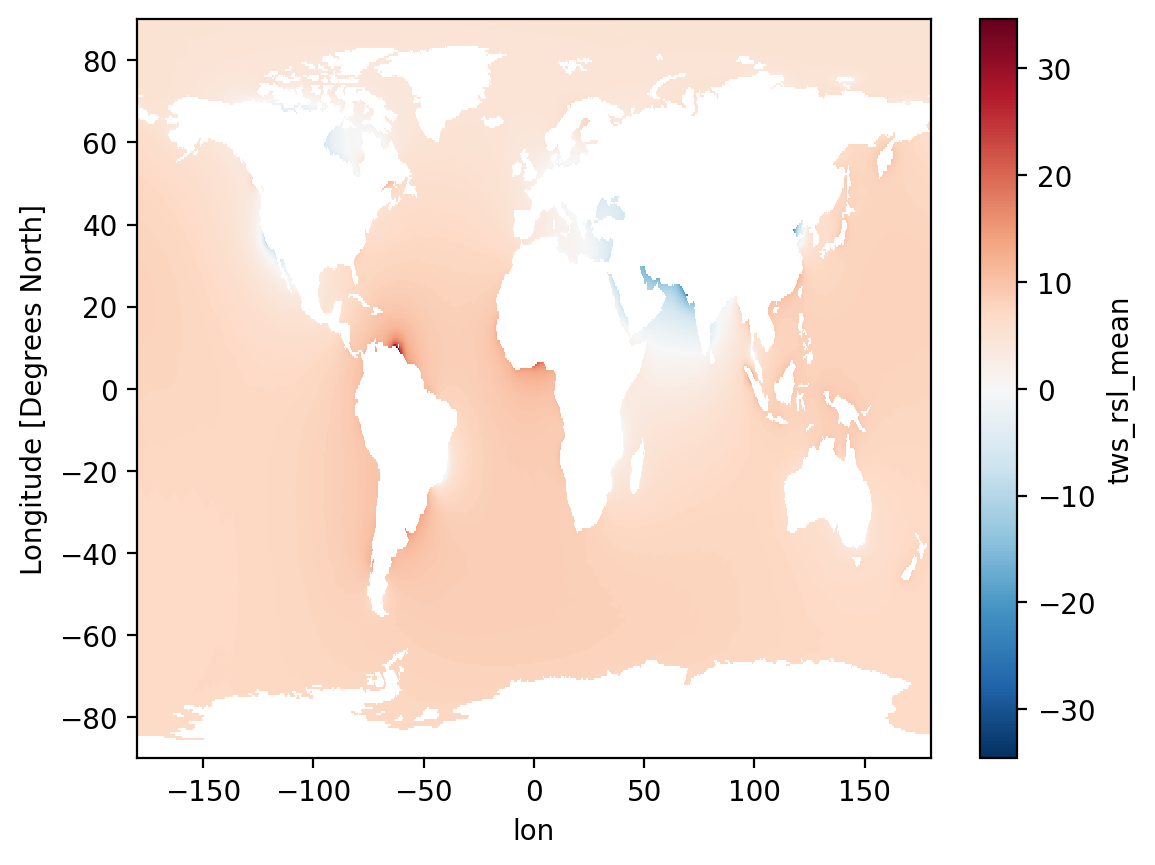

In [8]:
(tws_ds.tws_rsl_mean.sel(time = 2018) - tws_ds.tws_rsl_mean.sel(time = 1979)).plot()

In [9]:
tg_id = [20, 22, 23, 24, 25, 32]
coord = slc.tg_lat_lon(tg_id[0])

tws_df = slc.contrib_frederikse2020(coord, 'tws')

<AxesSubplot: xlabel='time'>

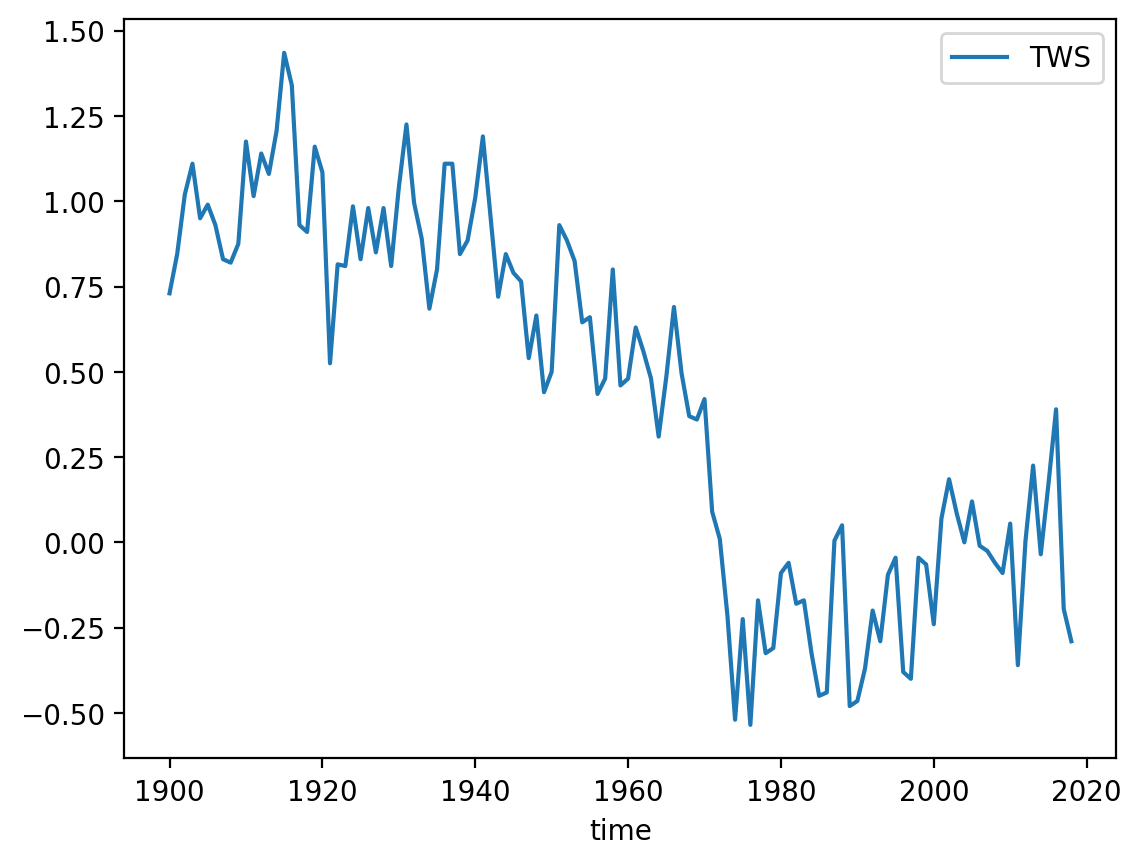

In [10]:
tws_df.plot() # .sel(time=2018).plot()

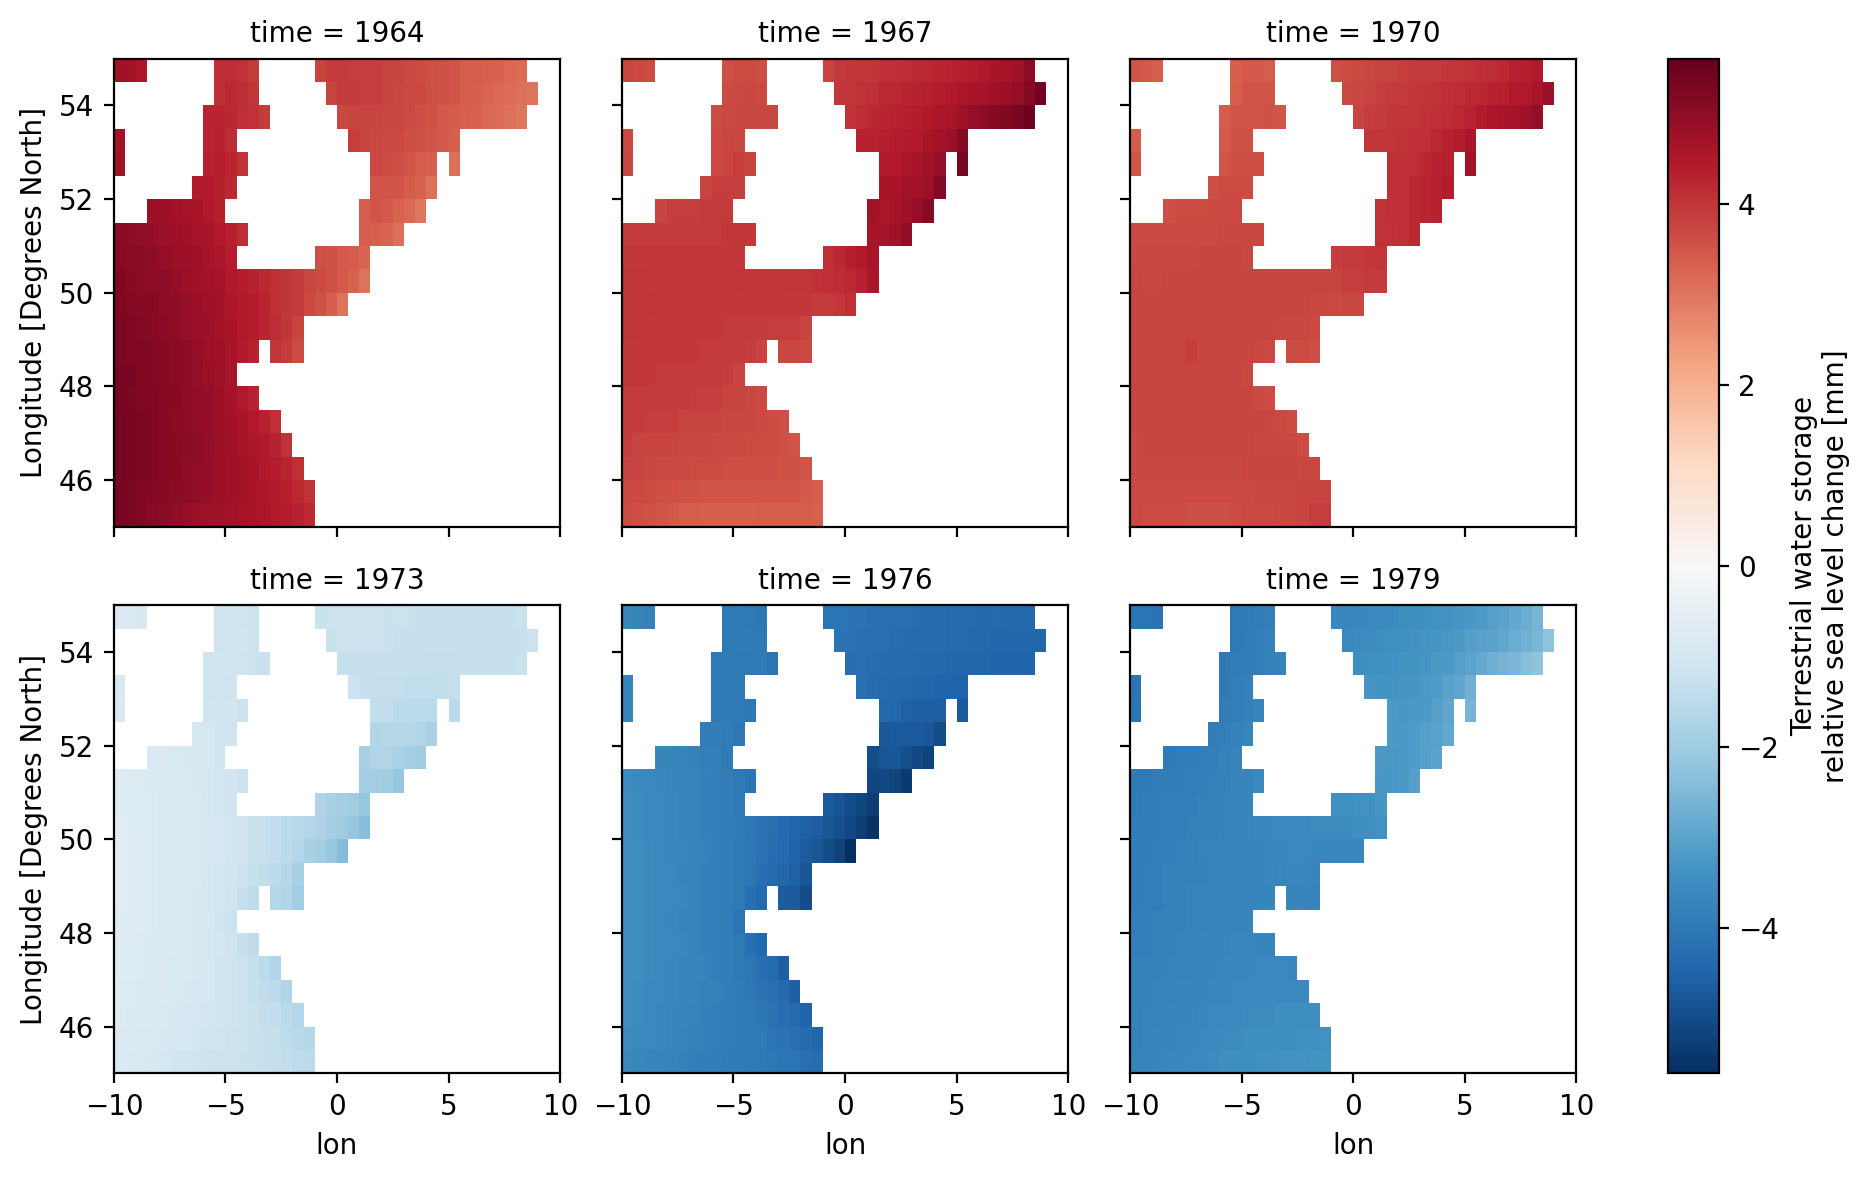

In [11]:
tws_sel = tws_ds.tws_rsl_mean.sel(time=slice(1964,1980,3) , lon=slice(-10,10), lat=slice(45,55))
tws_sel.plot(x='lon', y='lat', col='time', col_wrap=3)

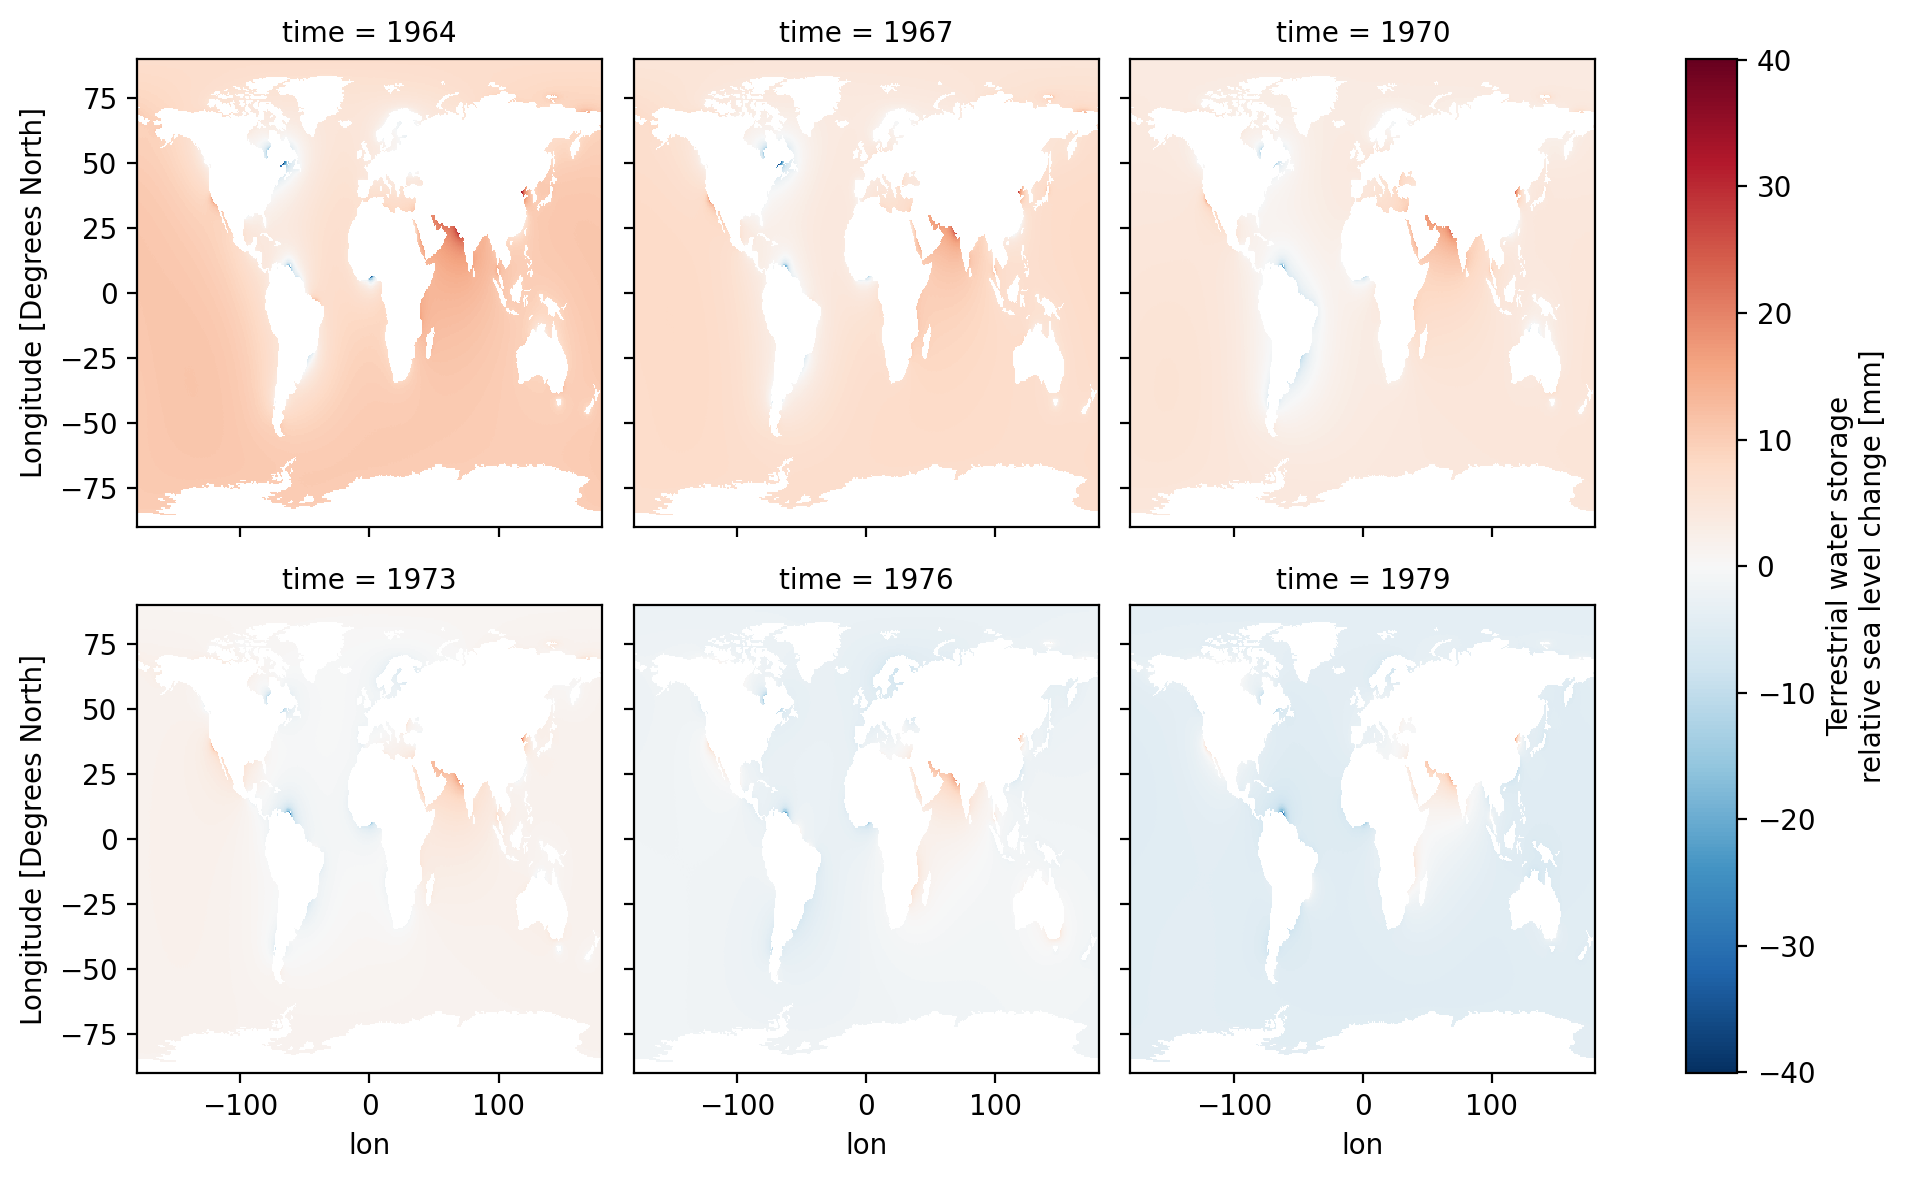

In [12]:
tws_sel = tws_ds.tws_rsl_mean.sel(time=slice(1964,1980,3))
tws_sel.plot(x='lon', y='lat', col='time', col_wrap=3)

## Steric

In [13]:
st_ds = xr.open_dataset(f'{data_dir}steric.nc')
st_ds = rotate_longitude(st_ds)

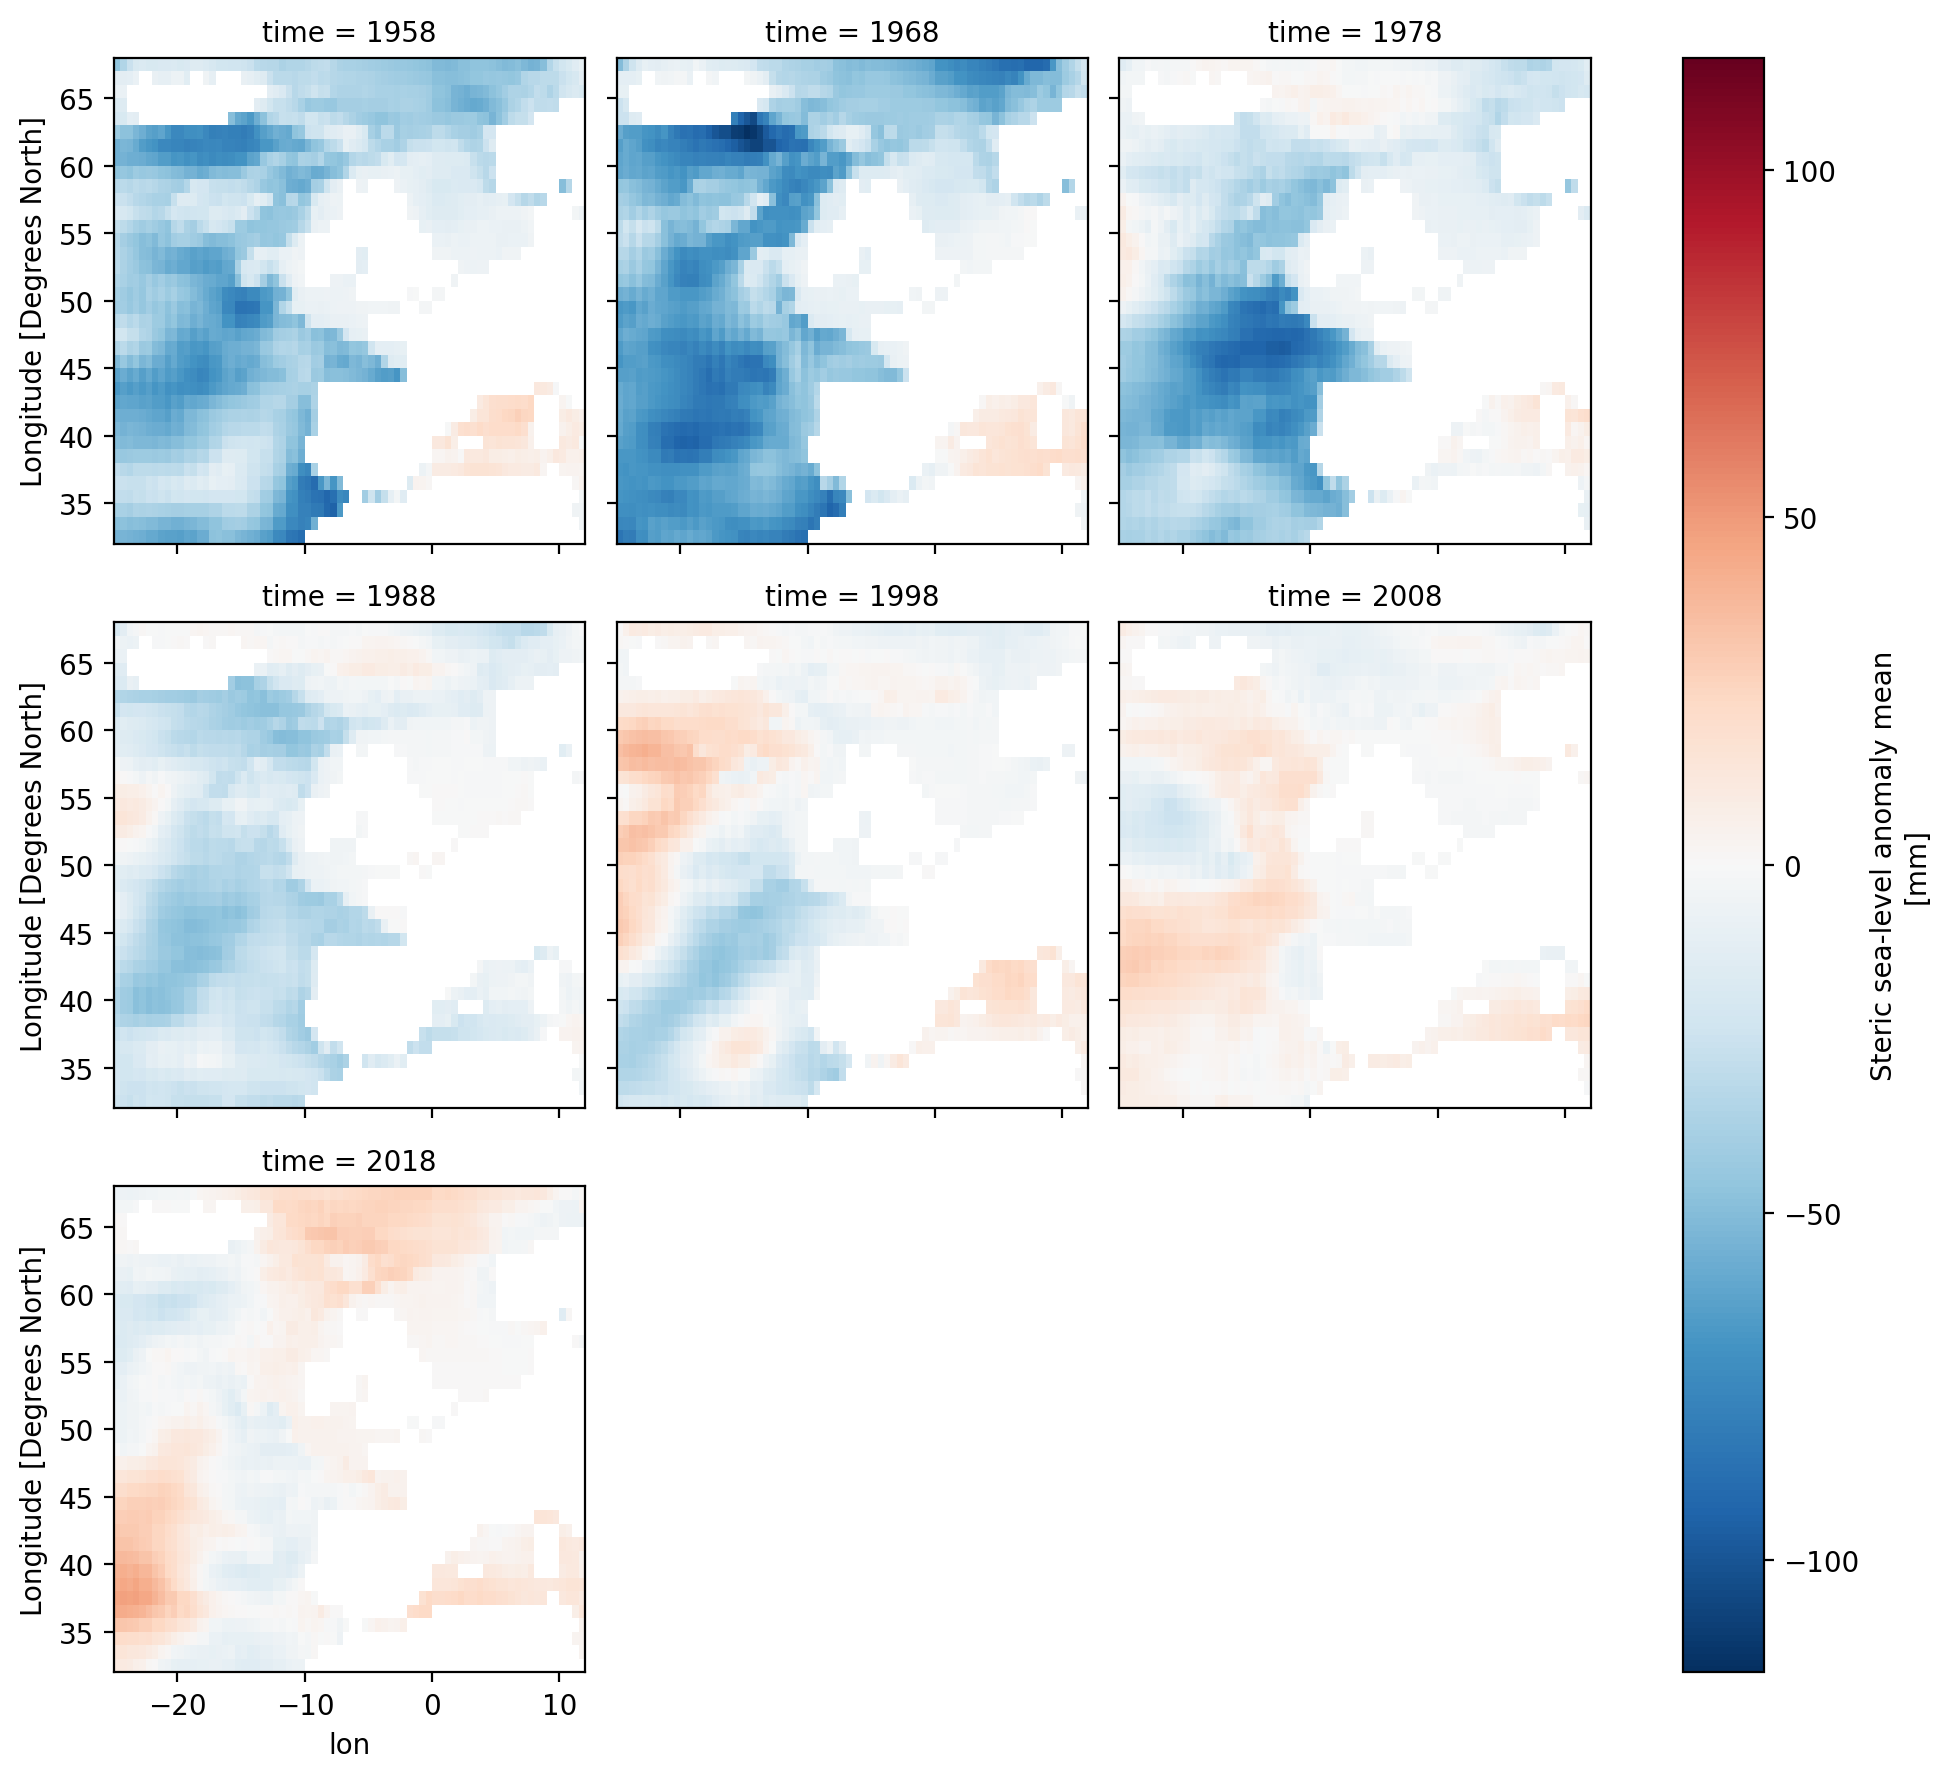

In [14]:
st_ds.steric_mean.sel(time=slice(1958,2018,10), lon=slice(-25,12), lat=slice(32,68)).plot(x='lon', y='lat', col='time', col_wrap=3)

## Check that the fields can be extrapollated up to 2020

- Add an extrap option to the function
- based on a linear extrap of the preious 5 or 10 years

In [16]:
tg_id = [20, 22, 23, 24, 25, 32]
TWS = slc.contrib_frederikse2020(tg_id, 'tws', extrap=True)
ANT = slc.contrib_frederikse2020(tg_id, 'AIS', extrap=True)
GRE = slc.contrib_frederikse2020(tg_id, 'GrIS', extrap=True)
GLA = slc.contrib_frederikse2020(tg_id, 'glac', extrap=True)

glo_steric_df = slc.contrib_frederikse2020_glob('GloSteric', extrap=True)

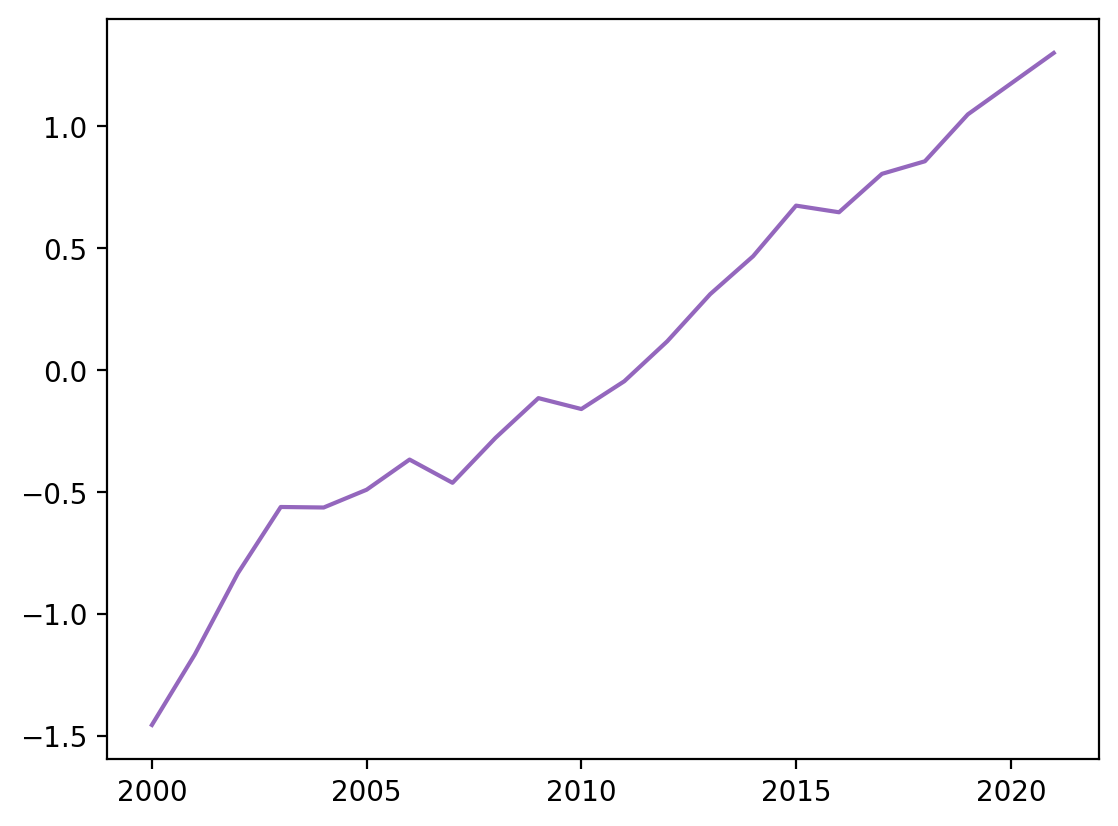

In [17]:
plt.plot(TWS.loc[2000:])
plt.plot(ANT.loc[2000:])
plt.plot(GRE.loc[2000:])
plt.plot(GLA.loc[2000:])
plt.plot(glo_steric_df.loc[2000:])

Looks good enough

## Read the region_info file

In [18]:
region_info_df = pd.read_excel(data_dir  + 'region_info.xlsx', sheet_name='Subpolar North Atlantic')

In [19]:
ZSM = [20, 22, 23, 24, 25, 32] # Tide gauge IDs of Zeespiegelmonitor
for tgi in ZSM:
    cond = (region_info_df['PSMSL IDs'] == str(tgi))
    print(region_info_df[cond])
                
               

    Unnamed: 0 Station names PSMSL IDs   Latitude  Longitude  First year  \
10          11    VLISSINGEN        20  51.442222   3.596111        1900   

    Last year  Number of annual observations  \
10       2018                            118   

                            VLM sources  Residual VLM [lower]  \
10  EEKL; OOS1; SASG; VLIS; ZEEB; ALTTG              -1.21633   

    Residual VLM [mean]  Residual VLM [upper]  
10            -0.433424              0.515838  
Empty DataFrame
Columns: [Unnamed: 0, Station names, PSMSL IDs, Latitude, Longitude, First year, Last year, Number of annual observations, VLM sources, Residual VLM [lower], Residual VLM [mean], Residual VLM [upper]]
Index: []
    Unnamed: 0 Station names PSMSL IDs   Latitude  Longitude  First year  \
12          13    DEN HELDER        23  52.964444      4.745        1900   

    Last year  Number of annual observations VLM sources  \
12       2018                            119       ALTTG   

    Residual VLM [lowe

## Check the use of radial velocity to obtain the absolute sea level budget

In [20]:
aa_ds = xr.open_dataset(f'{data_dir}AIS.nc')
aa_ds = rotate_longitude(aa_ds)


In [21]:
def plot_comp_rsl_rad(var, sel_region=False):

    ds = xr.open_dataset(f'{data_dir}{var}.nc')
    ds = rotate_longitude(ds)
    
    if sel_region:
        ds = ds.sel(lon=slice(-25,12), lat=slice(32,68))
    
    fig, ax = plt.subplots(1, 3, figsize=(12,3))

    rsl_sel = (ds[f'{var}_rsl_mean'].sel(time=2018) - 
               ds[f'{var}_rsl_mean'].sel(time=1900))
    
    rsl_sel.name = '' 

    rsl_sel.plot(ax=ax[0], robust=True)

    rad_sel = (ds[f'{var}_rad_mean'].sel(time=2018) - 
               ds[f'{var}_rad_mean'].sel(time=1900))
    
    rad_sel.name = '' 

    rad_sel.plot(ax=ax[1], robust=True)

    abs_sl = rsl_sel+rad_sel
    abs_sl.plot(ax=ax[2], robust=True)

    title = ['RSL', 'VLM', 'ABS=RSL+VLM']
    
    for i in range(3):
        ax[i].set_xlabel('')
        ax[i].set_ylabel('')
        ax[i].set_title(title[i])

    plt.tight_layout()

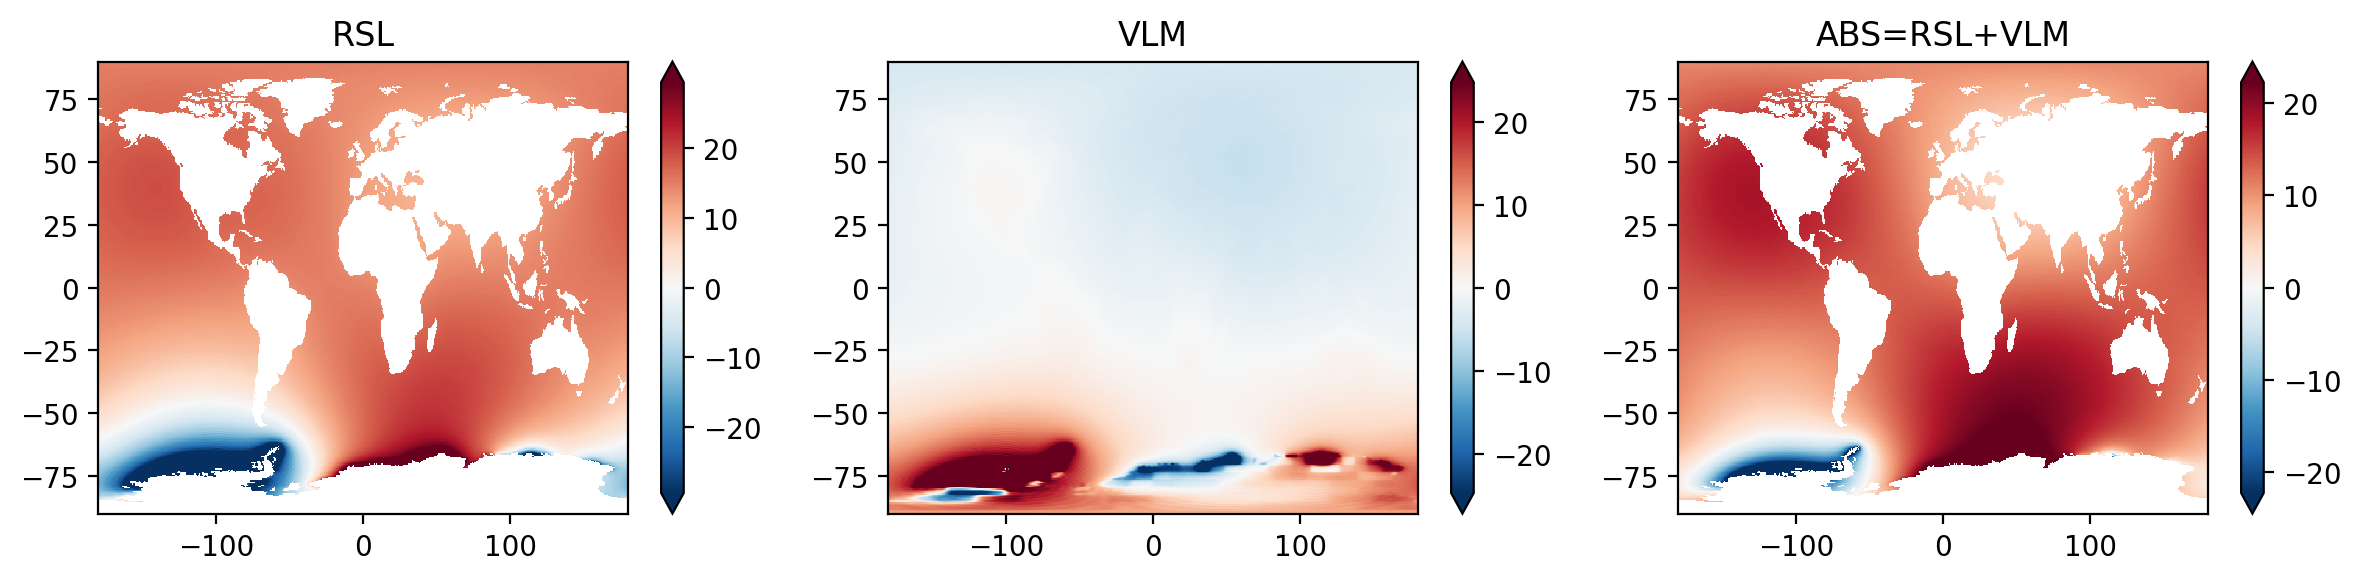

In [22]:
plot_comp_rsl_rad('AIS')

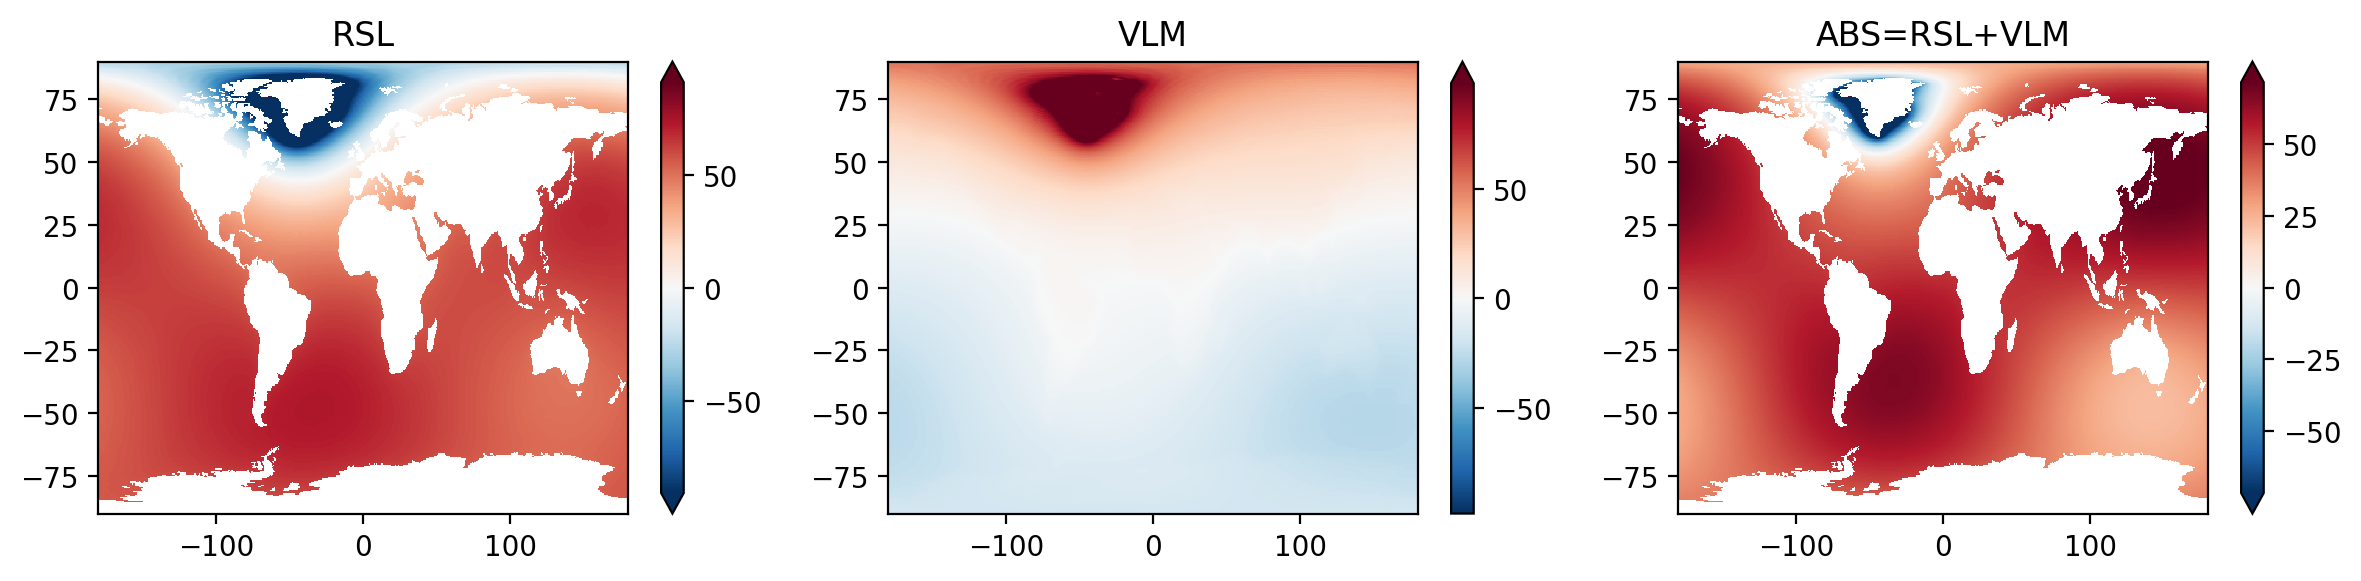

In [23]:
plot_comp_rsl_rad('GrIS')


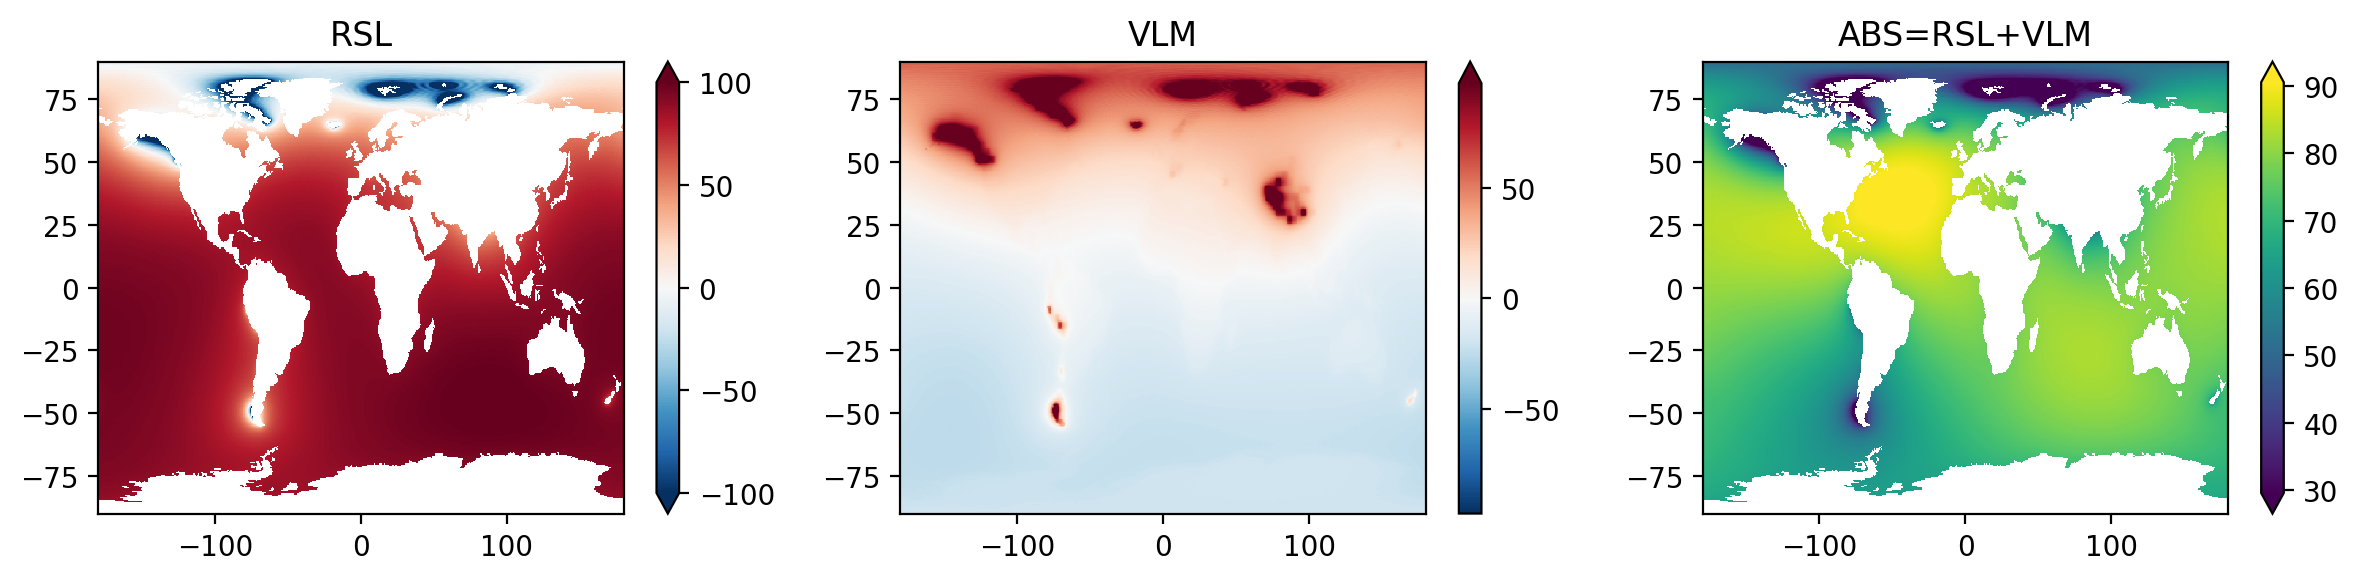

In [24]:
plot_comp_rsl_rad('glac')

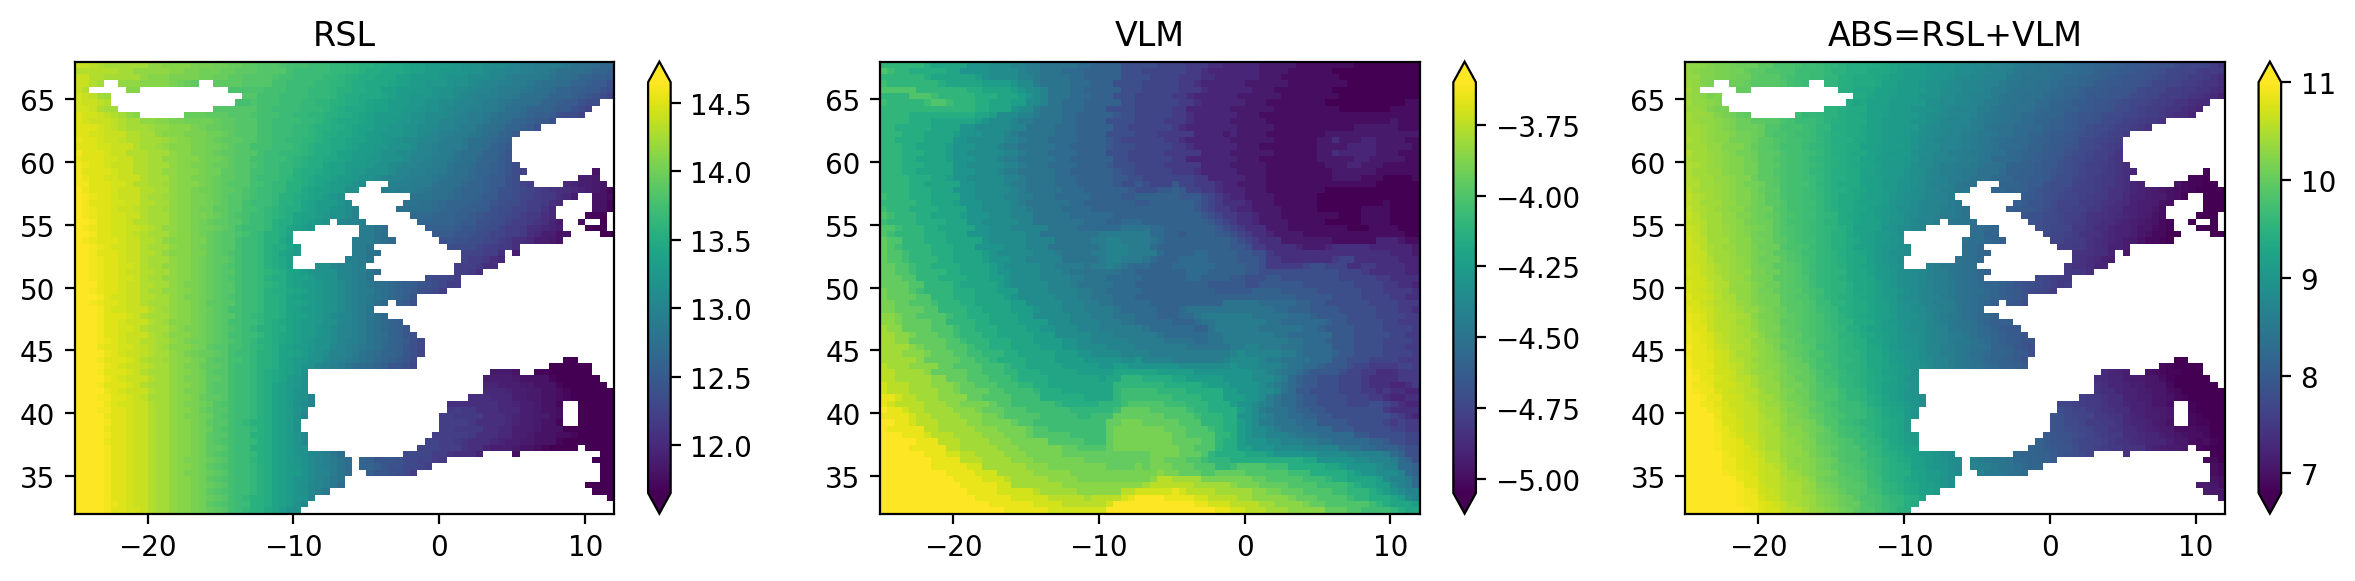

In [25]:
plot_comp_rsl_rad('AIS', True)

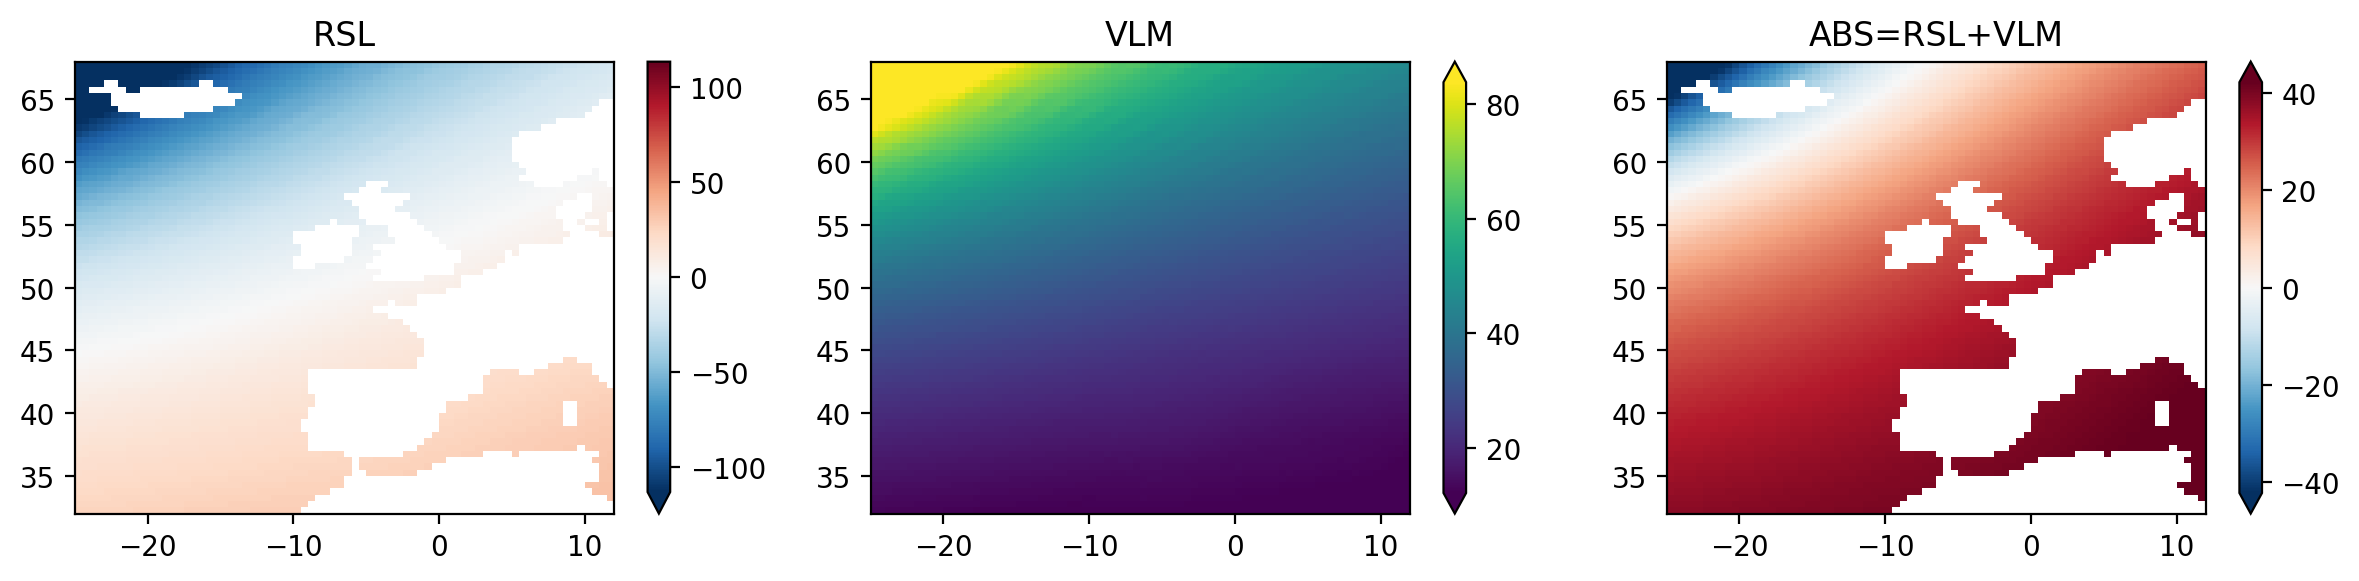

In [26]:
plot_comp_rsl_rad('GrIS', True)

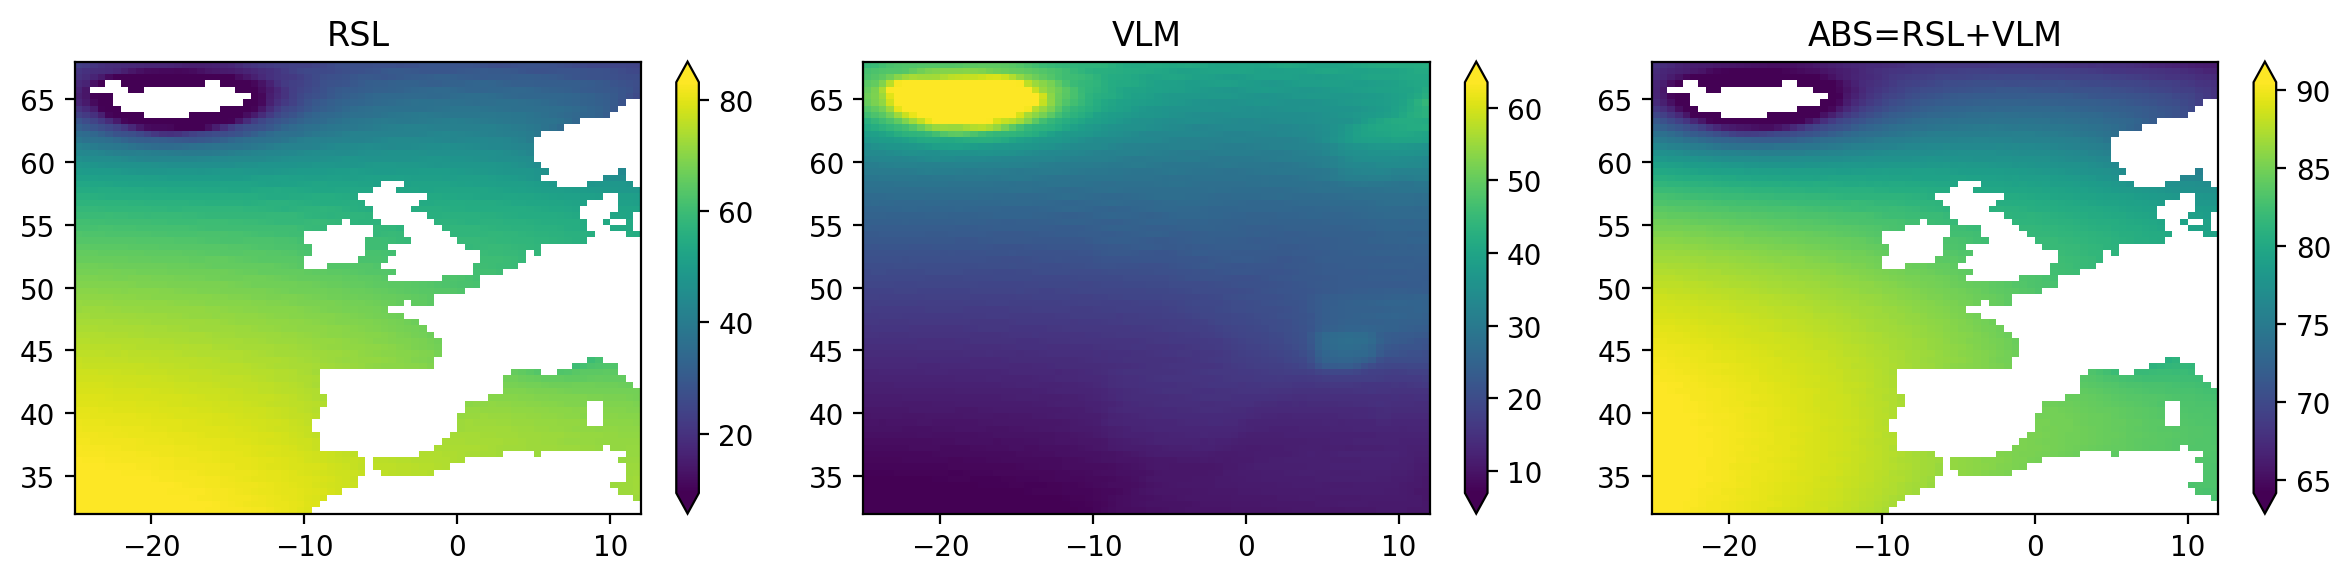

In [27]:
plot_comp_rsl_rad('glac', True)

## Compute the fingerprints evolution for absolute and relative sea level

In [28]:
#tg_id = [20, 22, 23, 24, 25, 32]
#coord = slc.tg_lat_lon(tg_id[0])

location = np.array([[2.5, 53], [3.3, 51.5], [4.25, 52.25], 
                    [4.75, 53.3], [5.5, 53.6], [7, 53.75], 
                    [7, 55], [4, 54.5]])
coord = [np.mean(location[:,1]), np.mean(location[:,0])]

In [29]:
def compute_fp(var, coord):
    '''Compute the different fingerprints'''
    loc_abs_df = slc.contrib_frederikse2020(coord, var, 'abs', True)
    loc_rsl_df = slc.contrib_frederikse2020(coord, var, 'rsl', True)
    glob_df = slc.contrib_frederikse2020_glob(var)
    
    out_names = {'tws' : 'TWS', 
                 'AIS' : 'Antarctica', 
                 'GrIS' : 'Greenland', 
                 'glac' : 'Glaciers',
                 'GloSteric' : 'Steric'}

    fp_abs = loc_abs_df.diff()/glob_df.diff()
    fp_abs = fp_abs.rename(columns={out_names[var]:
                                    f'{out_names[var]}_FP_abs'})

    fp_rsl = loc_rsl_df.diff()/glob_df.diff()
    fp_rsl = fp_rsl.rename(columns={out_names[var]:
                                    f'{out_names[var]}_FP_rsl'})

    fp = fp_abs.join(fp_rsl)
    
    return fp

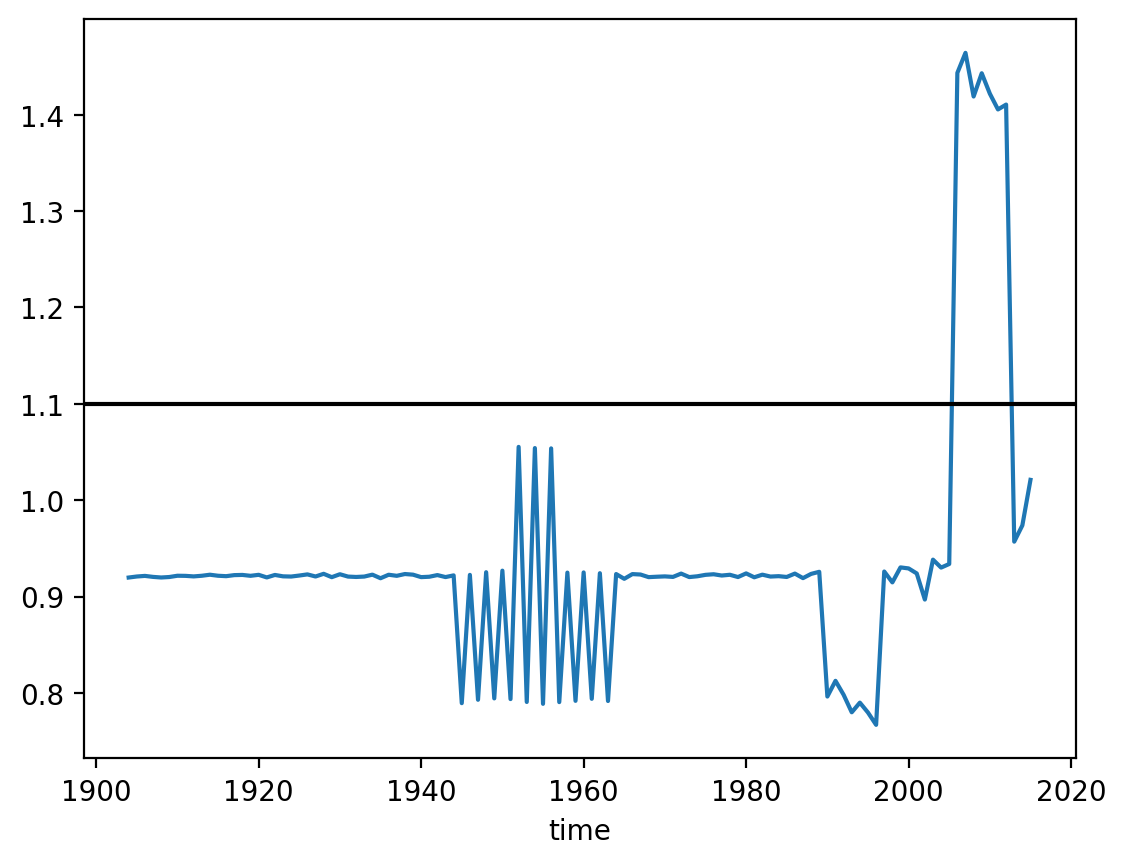

In [40]:
df = compute_fp('AIS', coord)

#df.rolling(7, center=True).mean().plot()
df['Antarctica_FP_rsl'].rolling(7, center=True).mean().plot()

plt.axhline(y=1.1, color="black")

In [42]:
df['Antarctica_FP_rsl'].loc[1995:2018].mean()

1.0895428055033531

<AxesSubplot: xlabel='time'>

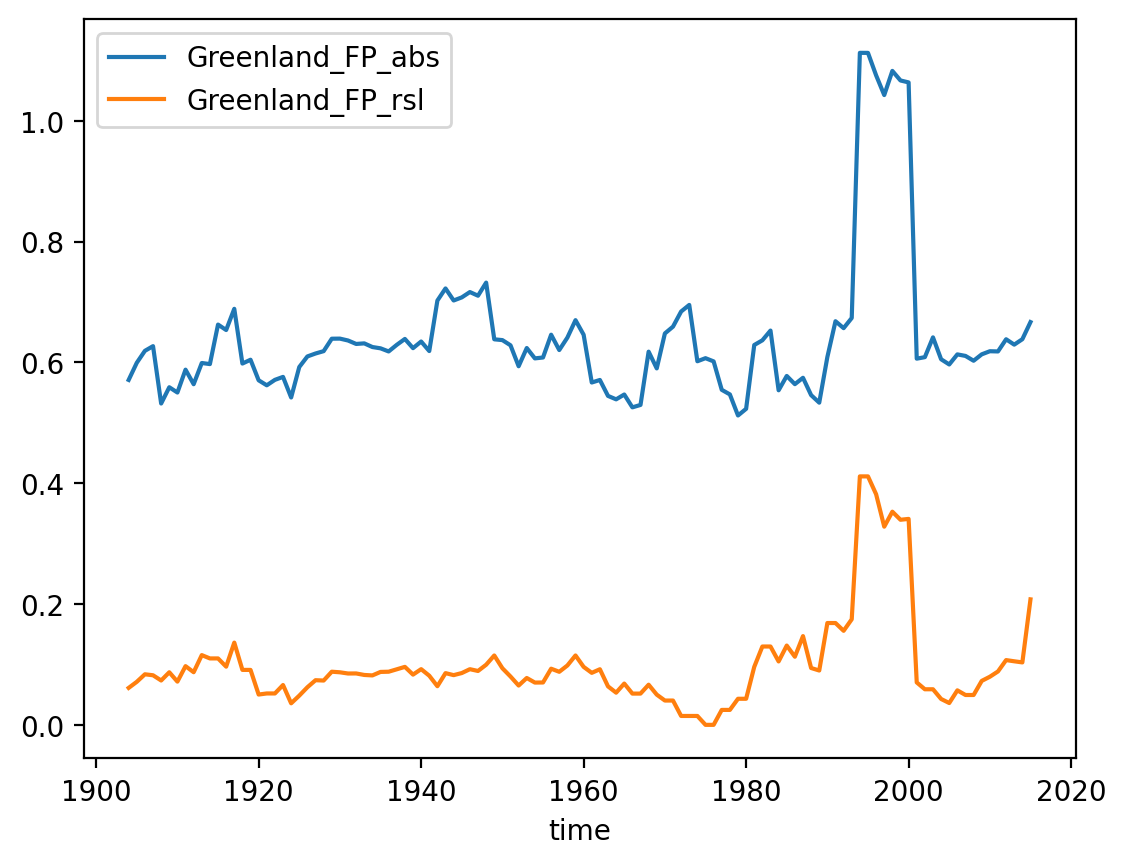

In [101]:
df = compute_fp('GrIS', coord)

df.rolling(7, center=True).mean().plot()

<AxesSubplot: xlabel='time'>

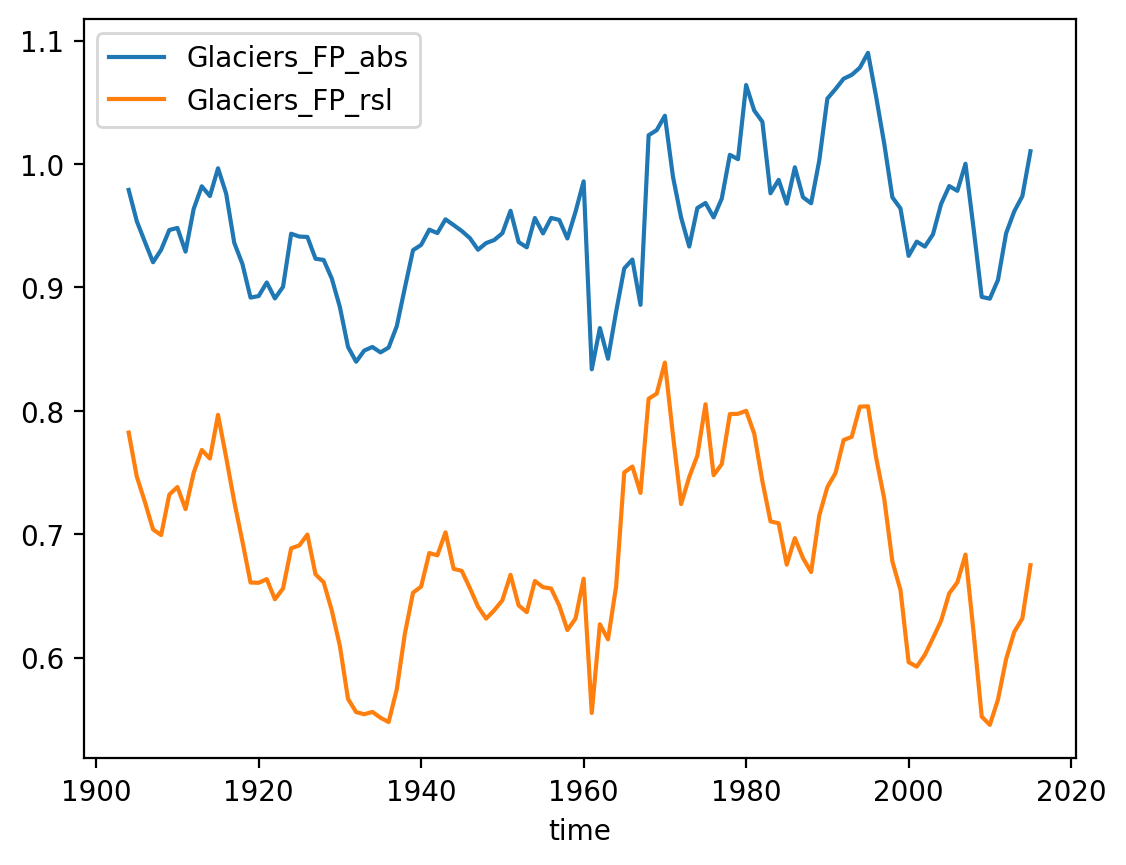

In [102]:
df = compute_fp('glac', coord)

df.rolling(7, center=True).mean().plot()

In [161]:
glob_df = slc.contrib_frederikse2020_glob('GloSteric')

In [162]:
glob_df

,GloSteric
time,
1900,-4.827935
1901,-4.914490
1902,-4.987756
1903,-5.110059
1904,-5.224018
...,...
2014,0.467003
2015,0.674470
2016,0.647246
